Loading cleaned data...
Data shape: (100000, 50)
Using 18 features
X shape: (100000, 18), y shape: (100000,)
Default rate: 18.05%

Train set: 70,000 samples
Test set: 30,000 samples
Train default rate: 18.05%
Test default rate: 18.04%
Training Logistic Regression...
Accuracy: 0.6571
Precision: 0.2906
Recall: 0.6246
F1 Score: 0.3966
ROC AUC: 0.7009
Training Random Forest...
Accuracy: 0.8197
Precision: 0.5038
Recall: 0.0364
F1 Score: 0.0679
ROC AUC: 0.6803
Training Gradient Boosting...
Accuracy: 0.8206
Precision: 0.5625
Recall: 0.0266
F1 Score: 0.0508
ROC AUC: 0.7035
Training XGBoost...
Accuracy: 0.8148
Precision: 0.4124
Recall: 0.0626
F1 Score: 0.1087
ROC AUC: 0.6834
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
2    Gradient Boosting  0.820633   0.562500  0.026603  0.050803  0.703457
0  Logistic Regression  0.657100   0.290564  0.624607  0.396622  0.700908
3              XGBoost  0.814767   0.412409  0.062627  0.108741  0.683402
1        Random Forest  0.819

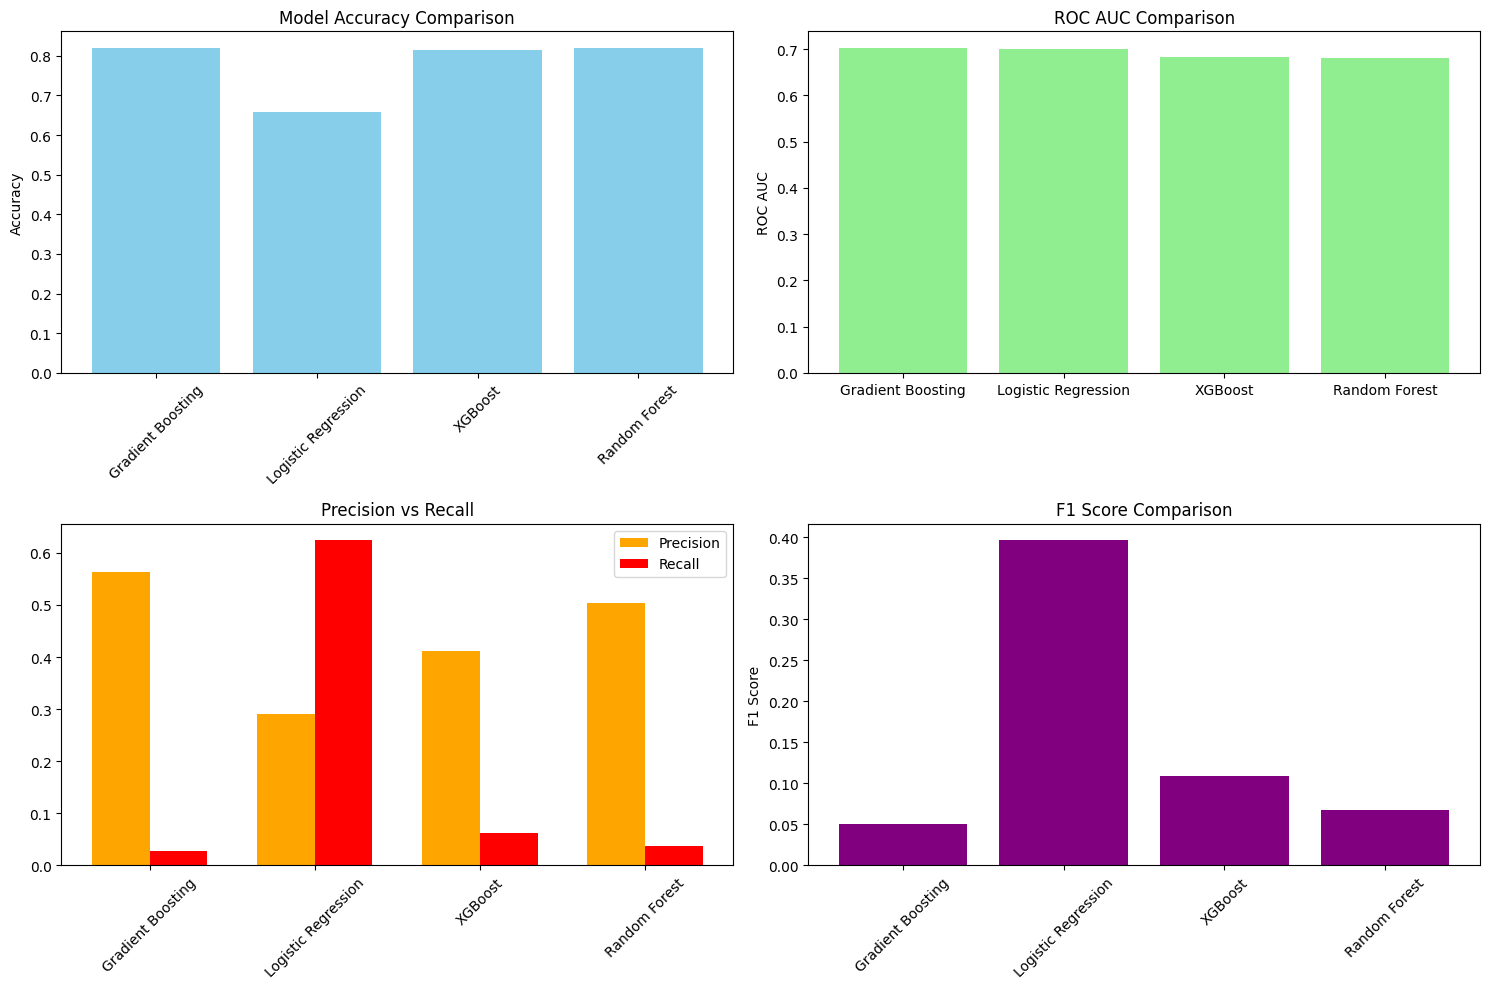


Feature Importance for Gradient Boosting
                        feature  importance
2                      int_rate    0.583130
14                   risk_score    0.196453
6        home_ownership_encoded    0.041226
13               loan_to_income    0.035684
10                    revol_bal    0.028244
0                     loan_amnt    0.021817
7                           dti    0.019551
9                      open_acc    0.018569
17  verification_status_encoded    0.012842
5                    annual_inc    0.011528
11                   revol_util    0.011401
16           addr_state_encoded    0.008956
12                    total_acc    0.004019
4            emp_length_numeric    0.003812
15              purpose_encoded    0.002769


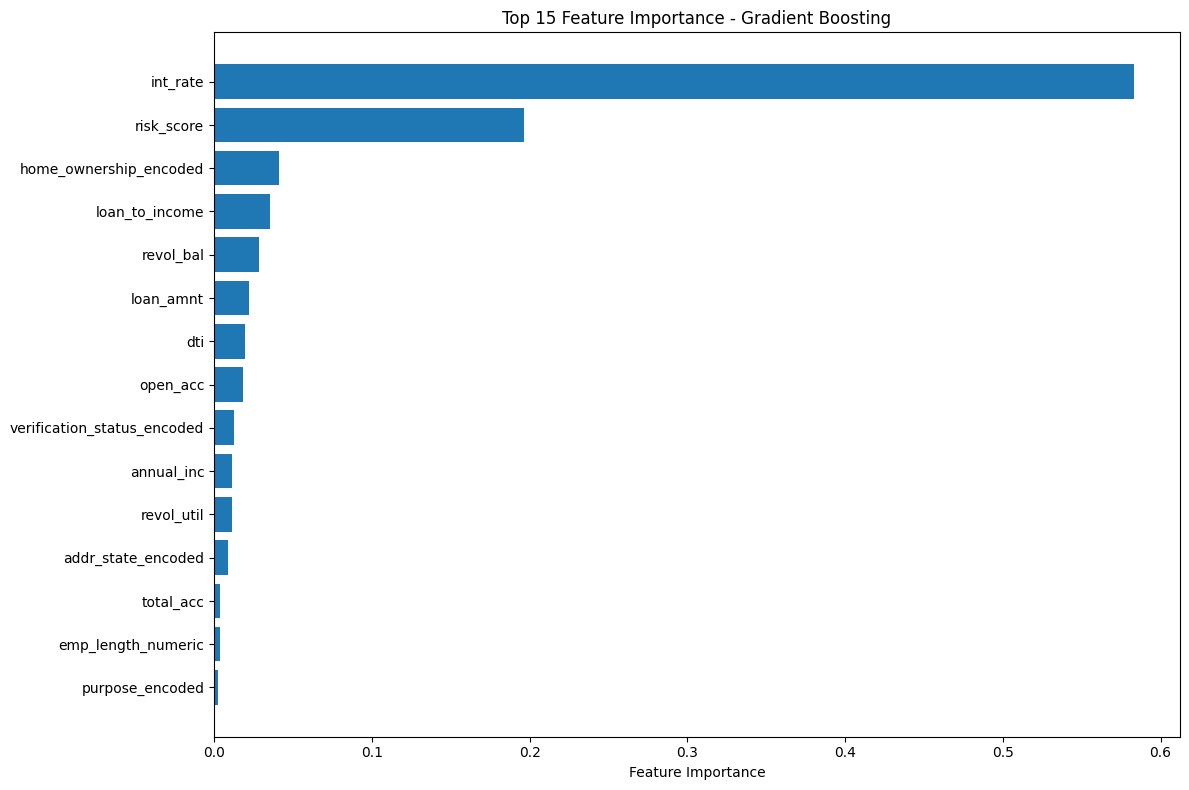

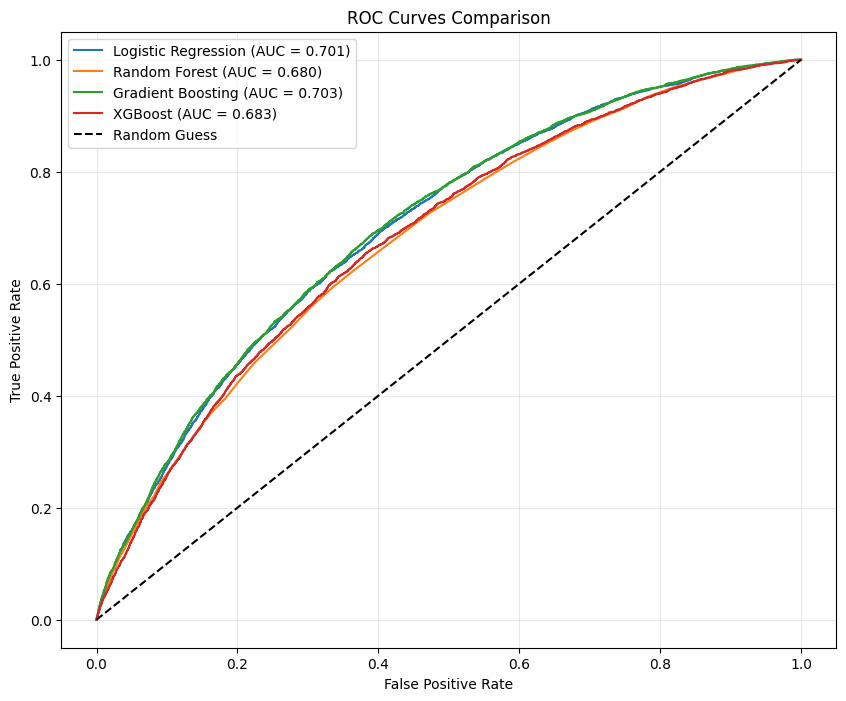

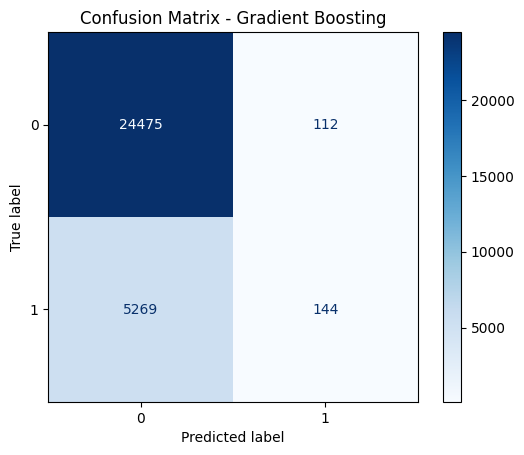


MODEL Scenario:
  total_profit: $70,806,120.00
  profit_from_good: $72,913,845.00
  loss_from_bad: $2,107,725.00
  missed_opportunity: $16,413,830.00

Model training completed!
Best model: Gradient Boosting
Saved to: models/gradient_boosting.pkl


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           accuracy_score, precision_score, recall_score, f1_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Loading cleaned data...")
df = pd.read_csv('../data/processed/cleaned_data.csv')
print(f"Data shape: {df.shape}")

feature_columns = [
    'loan_amnt', 'term_numeric', 'int_rate', 'installment',
    'grade_numeric', 'emp_length_numeric',
    
    'annual_inc', 'home_ownership_encoded', 'dti',
    
    'delinq_2yrs', 'inq_last_6mths', 'open_acc',
    'revol_bal', 'revol_util', 'total_acc',
    'pub_rec', 'collections_12_mths_ex_med',
    
    'loan_to_income', 'risk_score',
    
    'purpose_encoded', 'addr_state_encoded',
    'verification_status_encoded'
]
available_features = [col for col in feature_columns if col in df.columns]
print(f"Using {len(available_features)} features")

X = df[available_features].copy()
y = df['is_default'].copy()

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Default rate: {y.mean():.2%}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Train default rate: {y_train.mean():.2%}")
print(f"Test default rate: {y_test.mean():.2%}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, '../models/scaler.pkl')

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    joblib.dump(model, f'../models/{name.replace(" ", "_").lower()}.pkl')

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1 Score': [results[m]['f1'] for m in results],
    'ROC AUC': [results[m]['roc_auc'] for m in results]
})

results_df = results_df.sort_values('ROC AUC', ascending=False)
print(results_df)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].bar(results_df['Model'], results_df['Accuracy'], color='skyblue')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(results_df['Model'], results_df['ROC AUC'], color='lightgreen')
axes[0, 1].set_title('ROC AUC Comparison')
axes[0, 1].set_ylabel('ROC AUC')

width = 0.35
x = np.arange(len(results_df))
axes[1, 0].bar(x - width/2, results_df['Precision'], width, label='Precision', color='orange')
axes[1, 0].bar(x + width/2, results_df['Recall'], width, label='Recall', color='red')
axes[1, 0].set_title('Precision vs Recall')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(results_df['Model'], rotation=45)
axes[1, 0].legend()

axes[1, 1].bar(results_df['Model'], results_df['F1 Score'], color='purple')
axes[1, 1].set_title('F1 Score Comparison')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../reports/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

if hasattr(best_model, 'feature_importances_'):
    print(f"\nFeature Importance for {best_model_name}")
    
    feature_importance = pd.DataFrame({
        'feature': available_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(15))
    
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'][::-1])
    plt.yticks(range(len(top_features)), top_features['feature'][::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('../reports/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

plt.figure(figsize=(10, 8))
for name, result in results.items():
    y_pred_proba = result['model'].predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../reports/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, best_model.predict(X_test_scaled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.savefig('../reports/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

def calculate_business_metrics(y_true, y_pred, y_pred_proba, loan_amounts):
    profit_per_good = 0.20
    loss_per_bad = 1.00
    
    df_metrics = pd.DataFrame({
        'actual': y_true,
        'predicted': y_pred,
        'probability': y_pred_proba,
        'loan_amount': loan_amounts[:len(y_true)] 
    })
    
    scenarios = {}
    
    tp = df_metrics[(df_metrics['actual'] == 1) & (df_metrics['predicted'] == 1)]
    fp = df_metrics[(df_metrics['actual'] == 0) & (df_metrics['predicted'] == 1)]
    tn = df_metrics[(df_metrics['actual'] == 0) & (df_metrics['predicted'] == 0)]
    fn = df_metrics[(df_metrics['actual'] == 1) & (df_metrics['predicted'] == 0)]
    
    profit = (len(tn) * profit_per_good * tn['loan_amount'].mean() 
              if len(tn) > 0 else 0)
    loss = (len(fp) * loss_per_bad * fp['loan_amount'].mean() 
            if len(fp) > 0 else 0)
    missed_opportunity = (len(fn) * profit_per_good * fn['loan_amount'].mean() 
                          if len(fn) > 0 else 0)
    
    scenarios['model'] = {
        'total_profit': profit - loss,
        'profit_from_good': profit,
        'loss_from_bad': loss,
        'missed_opportunity': missed_opportunity
    }
    
    return scenarios

test_indices = X_test.index
loan_amounts_test = df.loc[test_indices, 'loan_amnt'] if 'loan_amnt' in df.columns else pd.Series([10000] * len(y_test))

business_metrics = calculate_business_metrics(
    y_test, 
    best_model.predict(X_test_scaled),
    best_model.predict_proba(X_test_scaled)[:, 1],
    loan_amounts_test
)

for scenario, metrics in business_metrics.items():
    print(f"\n{scenario.upper()} Scenario:")
    for metric, value in metrics.items():
        print(f"  {metric}: ${value:,.2f}")

print("\nModel training completed!")
print(f"Best model: {best_model_name}")
print(f"Saved to: models/{best_model_name.replace(' ', '_').lower()}.pkl")